In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
from tqdm import tqdm
from catboost import CatBoostRegressor

%matplotlib inline

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe


In [5]:
starting_directory = '.'

In [6]:
train_a = pd.read_parquet(f'{starting_directory}/A/train_targets.parquet')
train_b = pd.read_parquet(f'{starting_directory}/B/train_targets.parquet')
train_c = pd.read_parquet(f'{starting_directory}/C/train_targets.parquet')

In [7]:
X_train_estimated_a = pd.read_parquet(f'{starting_directory}/A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet(f'{starting_directory}/B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet(f'{starting_directory}/C/X_train_estimated.parquet')

X_train_observed_a = pd.read_parquet(f'{starting_directory}/A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet(f'{starting_directory}/B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet(f'{starting_directory}/C/X_train_observed.parquet')

X_test_estimated_a = pd.read_parquet(f'{starting_directory}/A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet(f'{starting_directory}/B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet(f'{starting_directory}/C/X_test_estimated.parquet')

In [8]:
def removeConstants(data):
    constant_columns = []
    set_num=0
    new_data = []

    for df in data:
        for column in df.columns:
            # Add constant
            if df[column].nunique() == 1 and set_num == 0:
                constant_columns.append(column)
            elif df[column].nunique() != 1 and column in constant_columns:
                # Pop impostor
                constant_columns.remove(column)
        set_num += 1
    
    for df in data:
        new_df = df.drop(columns=constant_columns)
        new_data.append(new_df)
    
    print("Column(s)", constant_columns, "was removed")
    return new_data

In [9]:
def fillNaN(data):
    new_data = []
    for df in data:
        for column in df.columns:
            df[column] = df[column].interpolate()
        new_data.append(df)
    return new_data

def quartersToHours(data):
    hourly_data = []
    for df in data:    
        df["year"] = df['date_forecast'].dt.year
        df["month"] = df['date_forecast'].dt.month
        df["day"] = df['date_forecast'].dt.day
        df["hour"] = df['date_forecast'].dt.hour
    
        group = df.groupby([df["year"], df["month"], df["day"], df["hour"]])  
        result = group.mean()
        result = result.reset_index()
    
        return_df = result.drop(['year', 'month', 'day', 'hour'], axis=1)
        
        hourly_data.append(return_df)

    return hourly_data

def convert_date_to_sin_and_cos(data):
    new_data = []
    for df in data:
        hour = 60*60
        day = 24*60*60
        year = (365.2425)*day
        month = year / 12.0
        
        df["year"] = [df["date_forecast"][i].year for i in range(len(df))]
        df["hour"] = [df["date_forecast"][i].hour for i in range(len(df))]
    
        date_time = pd.to_datetime(df.pop('date_forecast'), format='%Y-%m.%d %H:%M:%S')
        timestamp_s = date_time.map(pd.Timestamp.timestamp)
    
        df['hour_sin'] = np.sin(timestamp_s * (2 * np.pi / day))
        df['hour_cos'] = np.cos(timestamp_s * (2 * np.pi / day))
        df['year_sin'] = np.sin(timestamp_s * (2 * np.pi / year))
        df['year_cos'] = np.cos(timestamp_s * (2 * np.pi / year))
        new_data.append(df)
    return new_data


def appendLabels(train, val, labels):
    # Rename columns names to match
    val = val.assign(date_forecast=val.date_forecast.dt.round('H'))
    train = train.assign(date_forecast=train.date_forecast.dt.round('H'))

    labels = labels.rename(columns={'time': 'date_forecast'})
    
    joined_train = pd.merge(train, labels, how="inner", on="date_forecast")
    joined_val = pd.merge(val, labels, how="inner", on="date_forecast")

    return [joined_train, joined_val]

# Remove date columns
def removeNonNumeric(data):
    numeric_data = []
    for df in data:
        non_numeric_columns = df.select_dtypes(exclude='number').columns.tolist()
        df.drop(columns=non_numeric_columns, inplace=True)
        numeric_data.append(df)
    return numeric_data

def removeNaN(data):
    new_data = []
    for df in data:
        if 'pv_measurement' in df.columns:
            df = df.dropna(subset=['pv_measurement'])
        new_data.append(df)
    return new_data

In [10]:
A = [X_train_observed_a, X_train_estimated_a, X_test_estimated_a]
B = [X_train_observed_b, X_train_estimated_b, X_test_estimated_b]
C = [X_train_observed_c, X_train_estimated_c, X_test_estimated_c]

A = removeConstants(A)
A = removeConstants(B)
A = removeConstants(C)

A = quartersToHours(A)
B = quartersToHours(B)
C = quartersToHours(C)

A[:2] = appendLabels(A[0], A[1], train_a)
B[:2] = appendLabels(B[0], B[1], train_b)
C[:2] = appendLabels(C[0], C[1], train_c)

#A = convert_date_to_sin_and_cos(A)
#B = convert_date_to_sin_and_cos(B)
#C = convert_date_to_sin_and_cos(C)

A = fillNaN(A)
B = fillNaN(B)
C = fillNaN(C)

A = removeNonNumeric(A)
B = removeNonNumeric(B)
C = removeNonNumeric(C)

A = removeNaN(A)
B = removeNaN(B)
C = removeNaN(C)

Column(s) ['elevation:m', 'snow_drift:idx'] was removed
Column(s) ['elevation:m'] was removed
Column(s) ['elevation:m'] was removed


In [11]:
# Function to find and remove sequences with 12 or more identical subsequent values
def removeSequences(data):
    new_data = []
    for df in tqdm(data):
        start_idx = None
        prev_value = None
        subsequent_count = 0
        for idx, value in enumerate(df['pv_measurement']):
            if subsequent_count >= 1000:
                df = df.drop(df.index[idx-24:idx])
                subsequent_count == 0                
            
            if prev_value != None:
                if value - prev_value < 0.1:
                    subsequent_count += 1
            
                else:
                    prev_value = value
                    subsequent_count = 0
            else:
                prev_value = value
             
        new_data.append(df)

    return new_data


#A = removeSequences(A)
#B = removeSequences(B)
#C = removeSequences(C)

In [12]:
def combineAttributes(data):
    new_data = []
    for df in data:
        df['global_rad:W'] = df['direct_rad:W'] + df['diffuse_rad:W']
        df['global_rad_1h:J'] = df['direct_rad_1h:J'] + df['diffuse_rad_1h:J']
        
        df['diffuse_rad_ult'] = df['diffuse_rad_1h:J'] + df['diffuse_rad:W']
        df['direct_rad_ult'] = df['direct_rad_1h:J'] + df['direct_rad:W']

        df['ult_attribute'] = df['direct_rad_ult'] + df['diffuse_rad_ult']
        
        new_data.append(df)
    return new_data

A = combineAttributes(A)
B = combineAttributes(B)
C = combineAttributes(C)

In [13]:
def objective(space):
    
    model_a = CatBoostRegressor(
        learning_rate=space['learning_rate'],
        depth=space['depth'],
        loss_function='MAE'
    )
    model_b = CatBoostRegressor(
        learning_rate=space['learning_rate'],
        depth=space['depth'],
        loss_function='MAE'
    )
    model_c = CatBoostRegressor(
        learning_rate=space['learning_rate'],
        depth=space['depth'],
        loss_function='MAE'
    )

    #Fit the algorithm on the data
    model_a = model_a.fit(A[0].drop(columns=['pv_measurement']), A[0]['pv_measurement'])
    model_b = model_b.fit(B[0].drop(columns=['pv_measurement']), B[0]['pv_measurement'])
    model_c = model_c.fit(C[0].drop(columns=['pv_measurement']), C[0]['pv_measurement'])
        
    #Predict training set:
    validation_a = grid_search_a.predict(A[1])
    validation_b = grid_search_b.predict(B[1])
    validation_c = grid_search_c.predict(C[1])
    
    validation_a[validation_a < 0] = 0
    validation_b[validation_b < 0] = 0
    validation_c[validation_c < 0] = 0
    
    actual_values_a = A[1]['pv_measurement']
    actual_values_b = B[1]['pv_measurement']
    actual_values_c = C[1]['pv_measurement']
    
    error_a = np.mean(tf.keras.metrics.mean_absolute_error(
        actual_values_a, validation_a
    ))
    print(error_a)

    error_b = np.mean(tf.keras.metrics.mean_absolute_error(
        actual_values_b, validation_b
    ))
    print(error_b)
    
    error_c = np.mean(tf.keras.metrics.mean_absolute_error(
        actual_values_c, validation_c
    ))
    print(error_c)
    
    return {'loss' : error_a, 'status' : STATUS_OK}


space={
        'depth': hp.quniform('depth', 3, 10, 1),
        'learning_rate' : hp.quniform('learning-rate', 0, 2, 0.2),
    }


trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

print("The best hyperparameters are : ","\n")
print(best_hyperparams)

  0%|                                   | 0/100 [00:00<?, ?trial/s, best loss=?]0:	learn: 386.9695106	total: 112ms	remaining: 1m 51s
1:	learn: 269.7757428	total: 123ms	remaining: 1m 1s
2:	learn: 253.8221015	total: 136ms	remaining: 45.3s
3:	learn: 252.6030857	total: 147ms	remaining: 36.7s
4:	learn: 248.6289697	total: 158ms	remaining: 31.5s
5:	learn: 248.4474826	total: 174ms	remaining: 28.8s
6:	learn: 248.3227166	total: 184ms	remaining: 26.1s
7:	learn: 248.2698854	total: 194ms	remaining: 24s
8:	learn: 248.2552231	total: 204ms	remaining: 22.5s
9:	learn: 248.0526918	total: 213ms	remaining: 21.1s
10:	learn: 243.1620300	total: 223ms	remaining: 20.1s
11:	learn: 240.4241180	total: 241ms	remaining: 19.8s
12:	learn: 237.2535435	total: 260ms	remaining: 19.7s
13:	learn: 235.4941306	total: 271ms	remaining: 19.1s
14:	learn: 235.4286978	total: 280ms	remaining: 18.4s
15:	learn: 235.4280638	total: 292ms	remaining: 18s
16:	learn: 234.2353256	total: 306ms	remaining: 17.7s
17:	learn: 233.7922500	total: 31

job exception: name 'grid_search_a' is not defined



985:	learn: 16.9381285	total: 17.8s	remaining: 253ms
986:	learn: 16.9184651	total: 17.8s	remaining: 234ms
987:	learn: 16.9183105	total: 17.8s	remaining: 216ms
988:	learn: 16.9032532	total: 17.8s	remaining: 198ms
989:	learn: 16.8859424	total: 17.8s	remaining: 180ms
990:	learn: 16.8844250	total: 17.9s	remaining: 162ms
991:	learn: 16.8842718	total: 17.9s	remaining: 144ms
992:	learn: 16.8842670	total: 17.9s	remaining: 126ms
993:	learn: 16.8842593	total: 17.9s	remaining: 108ms
994:	learn: 16.8812758	total: 17.9s	remaining: 89.9ms
995:	learn: 16.8812506	total: 17.9s	remaining: 71.9ms
996:	learn: 16.8624031	total: 17.9s	remaining: 53.9ms
997:	learn: 16.8622954	total: 17.9s	remaining: 35.9ms
998:	learn: 16.8015979	total: 17.9s	remaining: 18ms
999:	learn: 16.8007498	total: 18s	remaining: 0us
  0%|                                   | 0/100 [00:52<?, ?trial/s, best loss=?]


NameError: name 'grid_search_a' is not defined

In [ ]:
model_a = CatBoostRegressor(learning_rate=1, depth=6, loss_function='MAE')
model_b = CatBoostRegressor(learning_rate=1, depth=6, loss_function='MAE')
model_c = CatBoostRegressor(learning_rate=1, depth=6, loss_function='MAE')

grid_search_a = model_a.grid_search({'learning_rate': [0.5, 1], 'depth': [5,6,7]}, A[0].drop(columns=['pv_measurement']), A[0]['pv_measurement'])
grid_search_b = model_b.grid_search({'learning_rate': [0.5, 1], 'depth': [5,6,7]}, A[0].drop(columns=['pv_measurement']), A[0]['pv_measurement'])
grid_search_c = model_c.grid_search({'learning_rate': [0.5, 1], 'depth': [5,6,7]}, A[0].drop(columns=['pv_measurement']), A[0]['pv_measurement'])

#model_a = model_a.fit(A[0].drop(columns=['pv_measurement']), A[0]['pv_measurement'])
#model_b = model_b.fit(B[0].drop(columns=['pv_measurement']), B[0]['pv_measurement'])
#model_c = model_c.fit(C[0].drop(columns=['pv_measurement']), C[0]['pv_measurement'])

0:	learn: 401.8267637	test: 399.5946121	best: 399.5946121 (0)	total: 6.16ms	remaining: 6.16s
1:	learn: 329.3583263	test: 324.5463591	best: 324.5463591 (1)	total: 12.4ms	remaining: 6.19s
2:	learn: 274.3930441	test: 273.6132729	best: 273.6132729 (2)	total: 19.6ms	remaining: 6.5s
3:	learn: 249.0328610	test: 248.9797351	best: 248.9797351 (3)	total: 30.2ms	remaining: 7.51s
4:	learn: 238.4481966	test: 238.1994746	best: 238.1994746 (4)	total: 43.2ms	remaining: 8.59s
5:	learn: 231.0178339	test: 231.1821301	best: 231.1821301 (5)	total: 52ms	remaining: 8.61s
6:	learn: 222.7479220	test: 223.8271176	best: 223.8271176 (6)	total: 58.3ms	remaining: 8.27s
7:	learn: 222.2127396	test: 223.3518177	best: 223.3518177 (7)	total: 65.4ms	remaining: 8.1s
8:	learn: 221.4542813	test: 223.1637064	best: 223.1637064 (8)	total: 71.5ms	remaining: 7.87s
9:	learn: 215.0565859	test: 217.0372814	best: 217.0372814 (9)	total: 78.5ms	remaining: 7.77s
10:	learn: 213.1825154	test: 215.4244856	best: 215.4244856 (10)	total: 84.

In [92]:
validation_a = grid_search_a.predict(A[1])
validation_b = grid_search_b.predict(B[1])
validation_c = grid_search_c.predict(C[1])

validation_a[validation_a < 0] = 0
validation_b[validation_b < 0] = 0
validation_c[validation_c < 0] = 0

actual_values_a = A[1]['pv_measurement']
actual_values_b = B[1]['pv_measurement']
actual_values_c = C[1]['pv_measurement']


print(np.mean(tf.keras.metrics.mean_absolute_error(
    actual_values_a, validation_a
)))
print(np.mean(tf.keras.metrics.mean_absolute_error(
    actual_values_b, validation_b
)))
print(np.mean(tf.keras.metrics.mean_absolute_error(
    actual_values_c, validation_c
)))

NameError: name 'grid_search_a' is not defined

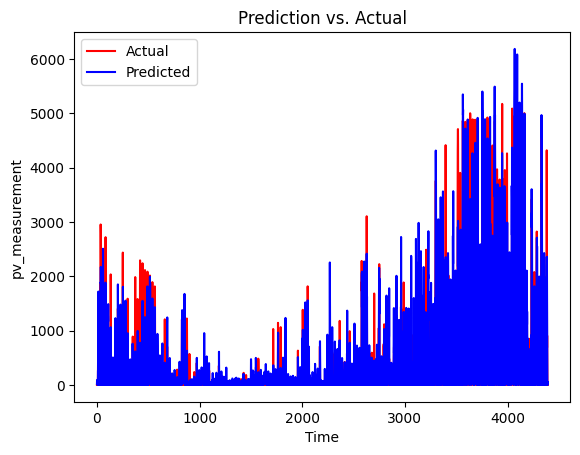

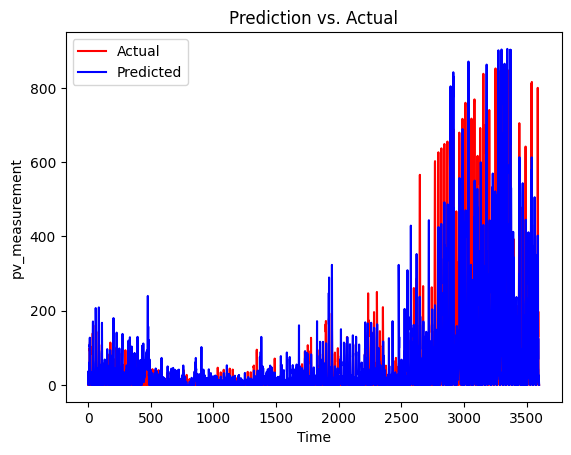

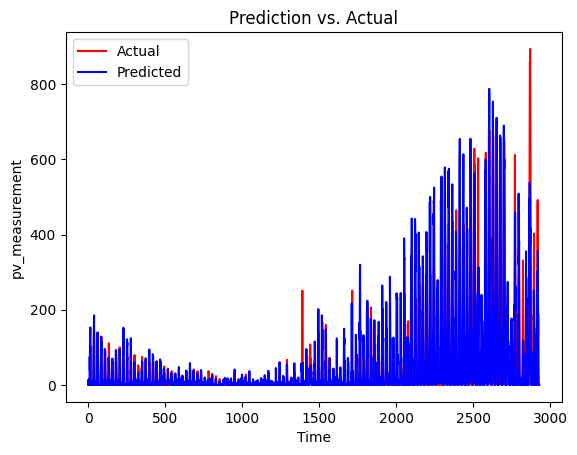

In [66]:
# Plotting Prediction vs. Actual
plt.plot(actual_values_a, label='Actual', color='red')
plt.plot(validation_a, label='Predicted', color='blue')
plt.xlabel('Time')
plt.ylabel('pv_measurement')
plt.title('Prediction vs. Actual')
plt.legend()
plt.show()

# Plotting Prediction vs. Actual
plt.plot(actual_values_b, label='Actual', color='red')
plt.plot(validation_b, label='Predicted', color='blue')
plt.xlabel('Time')
plt.ylabel('pv_measurement')
plt.title('Prediction vs. Actual')
plt.legend()
plt.show()

# Plotting Prediction vs. Actual
plt.plot(actual_values_c, label='Actual', color='red')
plt.plot(validation_c, label='Predicted', color='blue')
plt.xlabel('Time')
plt.ylabel('pv_measurement')
plt.title('Prediction vs. Actual')
plt.legend()
plt.show()

In [92]:
#meta_X = np.column_stack((validation_a., validation_b, validation_c))
#meta_model = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION)
#meta_model.fit(meta_X, y)
#combined_predictions = meta_model.predict(meta_X)

In [67]:
prediction_a = model_a.predict(A[2])
prediction_b = model_b.predict(B[2])
prediction_c = model_c.predict(C[2])

prediction_a[prediction_a < 0] = 0
prediction_b[prediction_b < 0] = 0
prediction_c[prediction_c < 0] = 0

submit = np.concatenate((np.concatenate((prediction_a, prediction_b)),prediction_c))

In [68]:
test = pd.read_csv('test.csv')

test

id                 time  prediction location
0        0  2023-05-01 00:00:00           0        A
1        1  2023-05-01 01:00:00           0        A
2        2  2023-05-01 02:00:00           0        A
3        3  2023-05-01 03:00:00           0        A
4        4  2023-05-01 04:00:00           0        A
...    ...                  ...         ...      ...
2155  2155  2023-07-03 19:00:00           0        C
2156  2156  2023-07-03 20:00:00           0        C
2157  2157  2023-07-03 21:00:00           0        C
2158  2158  2023-07-03 22:00:00           0        C
2159  2159  2023-07-03 23:00:00           0        C

[2160 rows x 4 columns]

In [69]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission

id  prediction
0        0           0
1        1           0
2        2           0
3        3           0
4        4           0
...    ...         ...
2155  2155           0
2156  2156           0
2157  2157           0
2158  2158           0
2159  2159           0

[2160 rows x 2 columns]

In [70]:
# Example, let the predictions be random values
test['prediction'] = submit
sample_submission = sample_submission[['id']].merge(test[['id', 'prediction']], on='id', how='left')
sample_submission.to_csv(".csv", index=False)

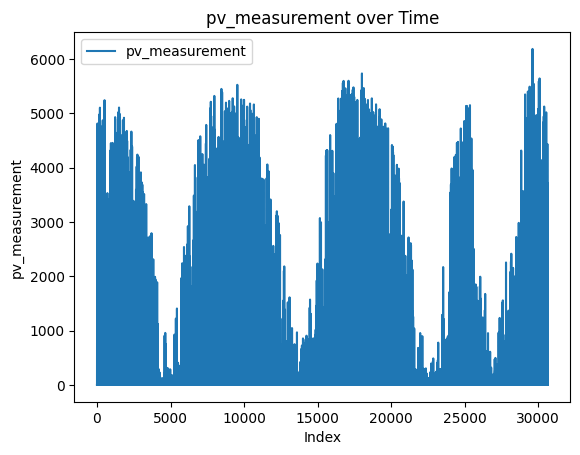

In [73]:
#Plot full sequence

pv_measurement_1 = A[0]['pv_measurement']

# Convert arr2 and arr3 to pandas Series
pv_measurement_2 = pd.Series(validation_a.flatten(), name='pv_measurement')
pv_measurement_3 = pd.Series(prediction_a.flatten(), name='pv_measurement')

# Concatenate the three Series
pv_measurement_combined = pd.concat([pv_measurement_1, pv_measurement_2, pv_measurement_3])

# Generate an index for the x-axis
index = range(len(pv_measurement_combined))

# Plot the data
plt.plot(index, pv_measurement_combined, label='pv_measurement')

# Add labels and title if needed
plt.xlabel('Index')
plt.ylabel('pv_measurement')
plt.title('pv_measurement over Time')

# Show the plot
plt.legend()
plt.show()

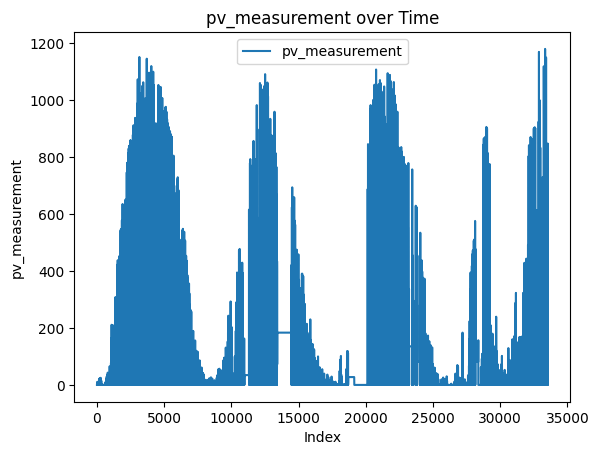

In [74]:
#Plot full sequence

pv_measurement_1 = B[0]['pv_measurement']

# Convert arr2 and arr3 to pandas Series
pv_measurement_2 = pd.Series(validation_b.flatten(), name='pv_measurement')
pv_measurement_3 = pd.Series(prediction_b.flatten(), name='pv_measurement')

# Concatenate the three Series
pv_measurement_combined = pd.concat([pv_measurement_1, pv_measurement_2, pv_measurement_3])

# Generate an index for the x-axis
index = range(len(pv_measurement_combined))

# Plot the data
plt.plot(index, pv_measurement_combined, label='pv_measurement')

# Add labels and title if needed
plt.xlabel('Index')
plt.ylabel('pv_measurement')
plt.title('pv_measurement over Time')

# Show the plot
plt.legend()
plt.show()

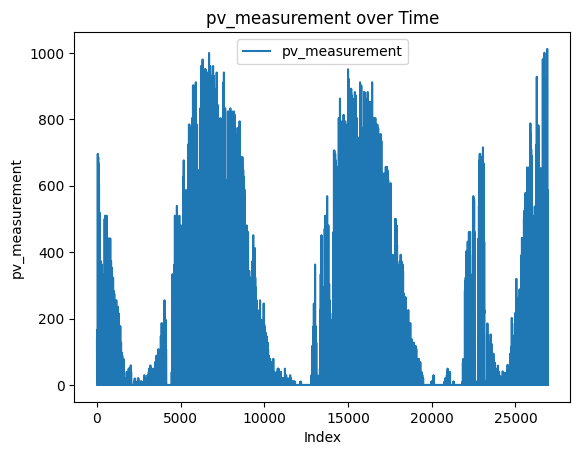

In [72]:
#Plot full sequence

pv_measurement_1 = C[0]['pv_measurement']

# Convert arr2 and arr3 to pandas Series
pv_measurement_2 = pd.Series(validation_c.flatten(), name='pv_measurement')
pv_measurement_3 = pd.Series(prediction_c.flatten(), name='pv_measurement')

# Concatenate the three Series
pv_measurement_combined = pd.concat([pv_measurement_1, pv_measurement_2, pv_measurement_3])

# Generate an index for the x-axis
index = range(len(pv_measurement_combined))

# Plot the data
plt.plot(index, pv_measurement_combined, label='pv_measurement')

# Add labels and title if needed
plt.xlabel('Index')
plt.ylabel('pv_measurement')
plt.title('pv_measurement over Time')

# Show the plot
plt.legend()
plt.show()